# Predicting Insurer Exits from Obamacare Exchanges

## Project Motivation and Summary  

Is there a way to alert policy makers before a health insurer stops offering insurance on Obamacare Exchanges?  These markets have been quite volatile as insurers figure out the characteristics of the market.  Is there a way to predict which 

### Cleaning and loading data
Proper local directory for loading in cleaning 

In [3]:
cd /Users/whetfield/Documents/data_science/metis_dsi/projects/proj3_McNulty/

/Users/whetfield/Documents/data_science/metis_dsi/projects/proj3_McNulty


In [4]:
#standard imports
import pandas as pd
import numpy  as np
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set()


#project specific modules
import mcnulty_cleaning as mc_clean
import mcnulty_analysis as mc_analysis

#If edit project specifif module, need to reload, not just import
from importlib import reload

In [5]:
cd ~/No_ICloud_Docs/health-insurance-marketplace/

/Users/whetfield/No_ICloud_Docs/health-insurance-marketplace


In [6]:
#Import CSVs on Service Area
df_servicearea_14_16 = pd.read_csv('ServiceArea.csv')
df_servicearea_17 = pd.read_csv('Service_Area_PUF_2017.csv')
df_servicearea_18 =pd.read_csv('Service_Area_PUF_2018.csv')

If make changes to project specific modules, change directory and reload if want to run them again in notebook

In [7]:
cd /Users/whetfield/Documents/data_science/metis_dsi/projects/proj3_McNulty/

/Users/whetfield/Documents/data_science/metis_dsi/projects/proj3_McNulty


In [8]:
reload(mc_clean)

<module 'mcnulty_cleaning' from '/Users/whetfield/Documents/data_science/metis_dsi/projects/proj3_McNulty/mcnulty_cleaning.py'>

In [9]:
reload(mc_analysis)

<module 'mcnulty_analysis' from '/Users/whetfield/Documents/data_science/metis_dsi/projects/proj3_McNulty/mcnulty_analysis.py'>

#### Cleaning Steps

Make dataframes which consolidate Service Area csv data by Year,County and Issuer to get count of plans offered by every issuer in each county each year.  Combine those dataframes.  Make lists for each issuer for the number of plans they offered the prior year and next year.  Add those lists to the dataframe and create binary target value if there is a valaue for plans offered this year and there wasn't the following year, then the target is 1.  The insurer left the county.  Next add percentage change in plans offered from prior year to current year, ie, does growing plans substantially, mean less likely to exit next year.  Or maybe closing many plans  but still remaining in the county means the insurer figured out their strategy and is likely to stay next year.  Set entering a county as just a very high but non-infinite, growth rate 

In [10]:
df_X_14_16 = mc_clean.create_df_plans_offered_for_year(df_servicearea_14_16)
df_X_17 = mc_clean.create_df_plans_offered_for_year(df_servicearea_17)
df_X_18 = mc_clean.create_df_plans_offered_for_year(df_servicearea_18)

df_X = None
df_X = pd.concat([df_X_14_16,df_X_17, df_X_18], ignore_index=True)

list_issuer_plans_next_year = mc_clean.plans_offered_next_year(df_X,2018)
list_issuer_plans_prior_year = mc_clean.plans_offered_prior_year(df_X,2014)


df_X = mc_clean.add_plans_offered_and_exit_county_target_columns_to_df(df_X,
                                                                       list_issuer_plans_next_year,
                                                                       list_issuer_plans_prior_year)

df_X = mc_clean.add_county_percentage_change_columns_to_df(df_X)

df_X.shape

(34025, 9)

In [11]:
cd ~/No_ICloud_Docs/health-insurance-marketplace/

/Users/whetfield/No_ICloud_Docs/health-insurance-marketplace


Now want to add population data for each county to the main dataframe.  Then want to add a metric for population per plans in the county.  Presumably too many plans for a given level of population will lead to exits

In [12]:
df_populations = pd.read_csv("County_Populations.csv", low_memory = False)
df_X = mc_clean.make_county_pops_names(df_X, df_populations)

In [13]:
df_X = mc_clean.make_total_plans_in_county_all_issuers(df_X)

/Users/whetfield/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/whetfield/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [14]:
df_X.columns

Index(['BusinessYear', 'County', 'StateCode', 'IssuerId',
       'Issuer_Plans_Offered_County', 'Issuer_Plans_Next_Year_County',
       'Issuer_Plans_Prior_Year_County', 'Exit_County_Next_Year',
       'Issuer_%_Change_Plans_From_Prior_Year', 'County_Population',
       'County_Name', 'Countywide_Plans_Current_Year',
       'Population_per_All_County_Plans', 'Countywide_Issuers_Current_Year',
       'Population_per_All_County_Issuers'],
      dtype='object')

#### Adding Rate Data to the Dataframe

Now we want to get data on the average premium insurers charged in the county and the state.  Do pricing strategies reveal intentions to exit in any way? Read in the rate csv data and get the median individual plan rate each issuer offered.  Rate level data not avaailable for county level and not sure what regulations would be about varying pricing from county to county.   Excluded any premiums above \$10,000 per month (assumed outlier) and below \$25 per month(no flag for dental plan in the rate.csvs, so assumed less than \$25 per month would be dental plan)

In [15]:
cd ~/No_ICloud_Docs/health-insurance-marketplace/

/Users/whetfield/No_ICloud_Docs/health-insurance-marketplace


In [16]:
df_median_rate_2014_2016 = mc_clean.create_median_rate_dataframe("Rate.csv")

df_median_rate_2017 = mc_clean.create_median_rate_dataframe("Rate_PUF_2017.csv")

df_median_rate_2018 = mc_clean.create_median_rate_dataframe("Rate_PUF_2018.csv")

df_all_median = pd.concat([df_median_rate_2014_2016,
                           df_median_rate_2017, 
                           df_median_rate_2018], ignore_index=True)

df_all_median.shape

(2873, 4)

Add what the issuer's median rate offered in the state was to the main dataframe as well as the average of the medians for all issuer's in the state

In [17]:
df_X = mc_clean.add_issuer_median_rate_offered_in_state(df_X,df_all_median)

Add prior year median for the issuer in the state and the state overall

In [18]:
df_test2 = mc_clean.median_rate_prior_year2(df_X,2014)

Sanity check... Aggregate the issuer median rate in state by the mean through a groupby  (first cell) versus directly calling the Average_Median_Rate_In_State column

In [19]:
Issuer_median_rate = df_test2.groupby(['StateCode',
                    'BusinessYear'], as_index = False )['Issuer_Median_Rate_in_State'].aggregate(lambda x: x.mean())

Issuer_median_rate.loc[Issuer_median_rate.StateCode == 'NC', :]

,StateCode,BusinessYear,Issuer_Median_Rate_in_State
78,NC,2014,394.266187
79,NC,2015,271.873563
80,NC,2016,391.466667
81,NC,2017,352.079096
82,NC,2018,376.005848


In [20]:
df_test2.loc[df_test2.StateCode == 'NC',][ 'Average_Median_Rate_in_State'].value_counts()

271.873563    348
391.466667    270
352.079096    177
376.005848    171
394.266187    139
Name: Average_Median_Rate_in_State, dtype: int64

Want to subset out 2014 and 2018 as we can't predict whether an issuer will remain in 2018 yet and 2014 was the first year.

In [21]:
df_test2 = df_test2[df_test2.BusinessYear != 2014]
df_test2 = df_test2[df_test2.BusinessYear != 2018]
df_test2.BusinessYear.value_counts()

2015    9476
2016    7976
2017    5991
Name: BusinessYear, dtype: int64

In [22]:
df_test2.Issuer_Prior_Year_Median_Rate_in_State.isnull().value_counts()

False    23443
Name: Issuer_Prior_Year_Median_Rate_in_State, dtype: int64

Now going to make rate percentage change columns for premium

In [23]:
df_test2 = mc_clean.add_rate_percentage_change_columns_to_df(df_test2)

In [24]:
df_test2.columns

Index(['BusinessYear', 'County', 'StateCode', 'IssuerId',
       'Issuer_Plans_Offered_County', 'Issuer_Plans_Next_Year_County',
       'Issuer_Plans_Prior_Year_County', 'Exit_County_Next_Year',
       'Issuer_%_Change_Plans_From_Prior_Year', 'County_Population',
       'County_Name', 'Countywide_Plans_Current_Year',
       'Population_per_All_County_Plans', 'Countywide_Issuers_Current_Year',
       'Population_per_All_County_Issuers', 'Issuer_Median_Rate_in_State',
       'Average_Median_Rate_in_State',
       'Issuer_Prior_Year_Median_Rate_in_State',
       'State_Prior_Year_Average_Median_Rate',
       'Issuer_Percent_Change_Rate_From_Prior_Year',
       'State_Percent_Change_Rate_From_Prior_Year'],
      dtype='object')

Can see the high number of 100000 values in 'Issuer_%_Change_Plans_From_Prior_Year' , which was the defalut value if the issuer didn't have plans that year, ie entered the county

In [25]:
df_test2['Issuer_%_Change_Plans_From_Prior_Year'].value_counts()

 0.000000         10884
 100000.000000     8572
 1.000000          1862
-0.500000          1005
 2.000000           338
 0.500000           267
 0.666667           134
-0.333333           109
 0.333333            72
-0.250000            37
 0.250000            36
-0.666667            36
 1.500000            34
 3.000000            18
-0.750000            15
 0.750000             5
 4.000000             5
-0.200000             4
-0.400000             2
-0.600000             2
-0.428571             1
 36.000000            1
-0.800000             1
 0.142857             1
 0.166667             1
 1.333333             1
Name: Issuer_%_Change_Plans_From_Prior_Year, dtype: int64

In [26]:
df_test2 = df_test2[df_test2.State_Prior_Year_Average_Median_Rate != 'state data not available']

Want to add flag for Medicaid expansion and whether it is is the first year in the market to get around the issue of what to set infinity

In [27]:
df_test2 = mc_clean.add_medicaid_expansion(df_test2)

In [28]:
df_test2 = mc_clean.add_first_year_in_county_flag(df_test2)

In [29]:
df_test2.columns

Index(['BusinessYear', 'County', 'StateCode', 'IssuerId',
       'Issuer_Plans_Offered_County', 'Issuer_Plans_Next_Year_County',
       'Issuer_Plans_Prior_Year_County', 'Exit_County_Next_Year',
       'Issuer_%_Change_Plans_From_Prior_Year', 'County_Population',
       'County_Name', 'Countywide_Plans_Current_Year',
       'Population_per_All_County_Plans', 'Countywide_Issuers_Current_Year',
       'Population_per_All_County_Issuers', 'Issuer_Median_Rate_in_State',
       'Average_Median_Rate_in_State',
       'Issuer_Prior_Year_Median_Rate_in_State',
       'State_Prior_Year_Average_Median_Rate',
       'Issuer_Percent_Change_Rate_From_Prior_Year',
       'State_Percent_Change_Rate_From_Prior_Year', 'Expansion',
       'First_Year_in_County'],
      dtype='object')

### Variable Summary 

**BusinessYear**: Year of exchange ranging from 2014 to 2018  
**County**:  FIPS county code   
**StateCode**:  Two digit state code  
**IssuerID**:  5-Digit HIOS Issuer ID code  
**Issuer_Plans_Offered_County**:  Total Number of Plans Offered by Issuer in County  
**Issuer_Plans_Next_Year_County**:  Total Number of Plans Offered by Issuer Next Year in County  

**Issuer_Plans_Offered_Prior_Year_County**:  Total Issuer Plans Offered Prior Year in County  
**Exit_County_Next_Year**: 1 for Exit, 0 for Stay -- **TARGET**  
**Issuer_%_Change_Plans_From_Prior_Year**: Percentage change in issuer plans offered from last year to this year  
**County_Population**: Population of County  
**County_Name**: County Actual Name  
**Countywide_Plans_Current_Year**: Total Plans in County from all issuers  
**Population_per_All_County_Plans**:  County Population divided by Total Plans in County 

**Population_per_All_County_Issuers**:  COunty population divided by Total Issuers in County

**Issuer_Median_Rate_in_State**:  Median individual premium offered by Issuer in state 

**Average_Median_Rate_in_State**: Average of all issuer Median rates for the State for given year  
       
**Issuer_Prior_Year_Median_Rate_in_State**: Prior year **Issuer_Median_Rate_in_State** 
       
**State_Prior_Year_Average_Median_Rate** : Prior year **Average_Median_Rate_in_State**   
       
**Issuer_Percent_Change_Rate_From_Prior_Year** : Percentage increase/decrease for issuer median rate in state 
       
**State_Percent_Change_Rate_From_Prior_Year** : Percentage increase/decrease from prior year to current at state level for average of issuer median  

**Expansion**:  1 if Medicaid was expanded in the state

**First Year in County**:  Flag if first year in county operating
       '

## EDA

In [30]:
X_analysis = df_test2

In [31]:
8215 / (8215 + 14652)

0.3592513228670136

In [32]:
X_analysis.Exit_County_Next_Year.value_counts()

0    14652
1     8215
Name: Exit_County_Next_Year, dtype: int64

Most issuers only have one plan offered in a county each year. Note this is different than having multiple rates for different ages, benefit levels.  More detaild schema in HIOS data is Plan Variant

In [33]:
X_analysis.Issuer_Plans_Offered_County.value_counts()

1     15369
2      4776
3      1632
4       687
5       371
6        12
7        10
8         5
10        2
14        1
74        1
37        1
Name: Issuer_Plans_Offered_County, dtype: int64

Looking at average of different potential features within the two target variables.  Population per all county plans directionally makes sense as there are fewer people per total plans offered in counties where exit occurred.  Similarly for the Population per the number of issuers.  Don't have any intuition around premiums being higher or lower in one versus the other. All things equal, higher premiums would mean more profits.  Obviously all things are never equal

In [34]:
X_analysis[['Population_per_All_County_Plans',
            'Population_per_All_County_Issuers',
            'Issuer_%_Change_Plans_From_Prior_Year',
            'State_Percent_Change_Rate_From_Prior_Year']] = X_analysis.loc[:,['Population_per_All_County_Plans',
                                                                                'Population_per_All_County_Issuers',
                                                            'Issuer_%_Change_Plans_From_Prior_Year',
                                                              'State_Percent_Change_Rate_From_Prior_Year']].apply(pd.to_numeric)

X_analysis.groupby(['Exit_County_Next_Year'])[['Population_per_All_County_Plans', 
                                               'Population_per_All_County_Issuers',
                                               'Average_Median_Rate_in_State',
                                               ]].mean()

,Population_per_All_County_Plans,Population_per_All_County_Issuers,Average_Median_Rate_in_State
Exit_County_Next_Year,,,
0,20369.163533,28450.193176,395.023986
1,16722.141970,22851.184976,361.804386


Issuer percent change from prior year I set to 100,000 if the issuer entered the county from prior year.  So giving a similar signal. The overall state percentage rate change from prior year could make some sense, if able to raise premiums more  then more likely to stay in state.  Fair amount of regulation in premium increases so perhaps if could raise rates more in certain states more likely to stay in state.

In [35]:
X_analysis.groupby(['Exit_County_Next_Year'])[['Issuer_Percent_Change_Rate_From_Prior_Year',
                                               'State_Percent_Change_Rate_From_Prior_Year']].mean()
                                               

,Issuer_Percent_Change_Rate_From_Prior_Year,State_Percent_Change_Rate_From_Prior_Year
Exit_County_Next_Year,,
0,-35209.183724,19.062585
1,-35470.864461,12.805633


In [36]:
X_analysis.groupby(['Exit_County_Next_Year'])[['Expansion',
                                               'First_Year_in_County']].mean()

,Expansion,First_Year_in_County
Exit_County_Next_Year,,
0,0.345345,0.306852
1,0.431163,0.472794


Look at Seaborn pair plots

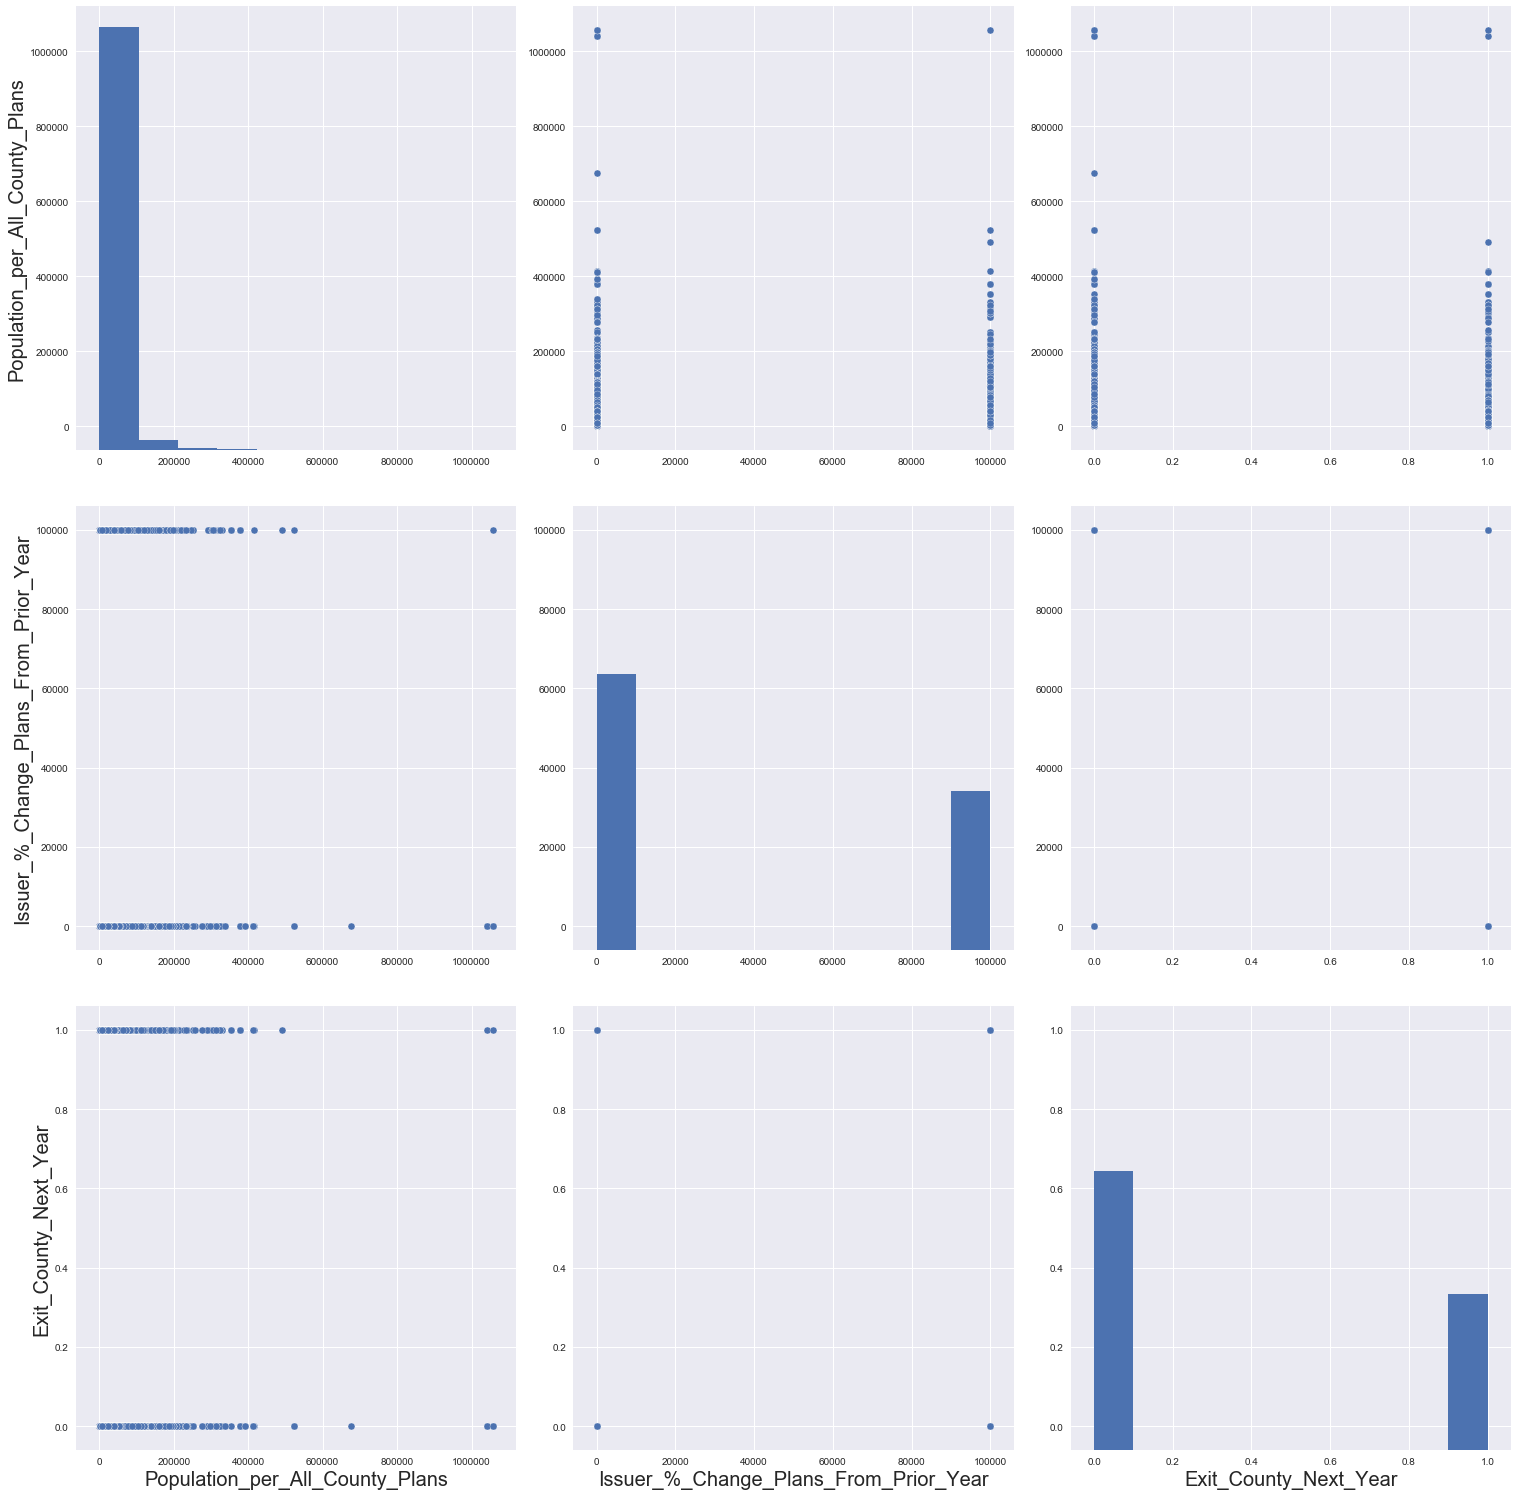

In [37]:
sns.set()
plt.rcParams["axes.labelsize"] = 20
sns.pairplot(X_analysis.loc[:,['Population_per_All_County_Plans', 'Issuer_%_Change_Plans_From_Prior_Year',
                               'Exit_County_Next_Year' ]], size = 7, aspect = 1)

Text(0.5,1,'County Population per Plan and Average $ Premium')

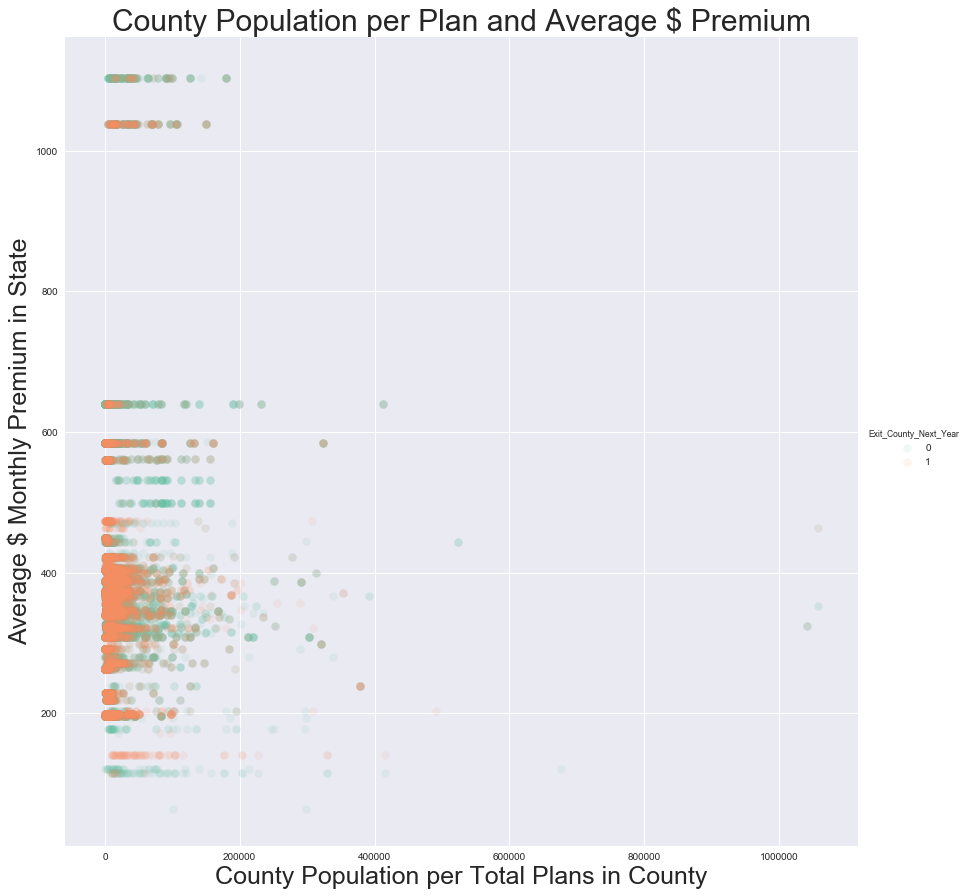

In [38]:
plt.rcParams["axes.labelsize"] = 10


sns.lmplot('Population_per_All_County_Plans', 'Average_Median_Rate_in_State', data=X_analysis, hue='Exit_County_Next_Year', palette='Set2', fit_reg=False, 
           scatter_kws={"s": 70, 'alpha':0.1}, size=12, aspect = 1)

sns.set(font_scale = 2)
ax = plt.gca()
ax.set_xlabel('County Population per Total Plans in County', fontsize=25)
ax.set_ylabel ('Average $ Monthly Premium in State', fontsize = 25)
ax.set_title("County Population per Plan and Average $ Premium", fontsize=30)

In [39]:
X_analysis[['Population_per_All_County_Plans', 'Expansion',
          'First_Year_in_County', 'Average_Median_Rate_in_State', 'State_Percent_Change_Rate_From_Prior_Year']].corr()

,Population_per_All_County_Plans,Expansion,First_Year_in_County,Average_Median_Rate_in_State,State_Percent_Change_Rate_From_Prior_Year
Population_per_All_County_Plans,1.000000,0.031502,-0.034882,0.085643,0.056370
Expansion,0.031502,1.000000,0.100731,-0.235207,-0.198789
First_Year_in_County,-0.034882,0.100731,1.000000,-0.140625,-0.020497
Average_Median_Rate_in_State,0.085643,-0.235207,-0.140625,1.000000,0.734698
State_Percent_Change_Rate_From_Prior_Year,0.056370,-0.198789,-0.020497,0.734698,1.000000


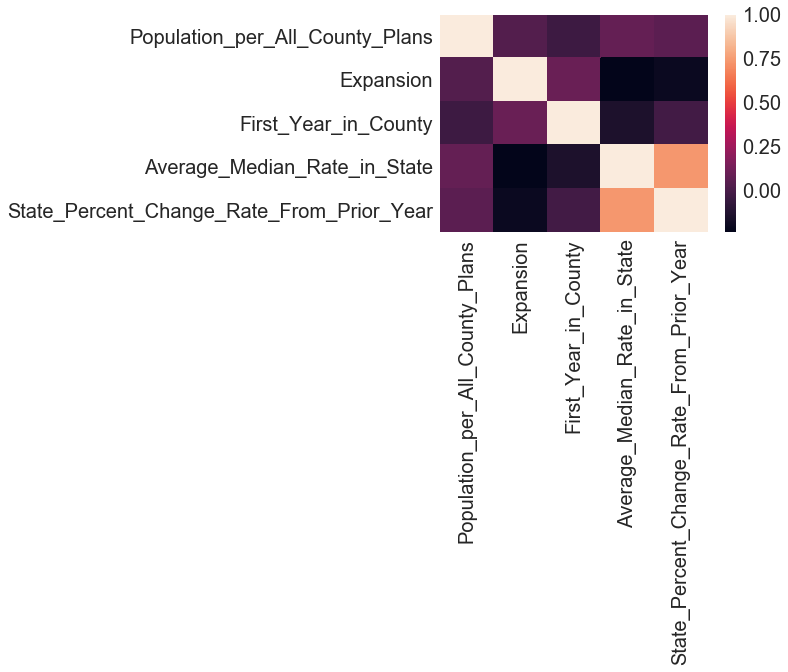

In [40]:

import seaborn as sns
%matplotlib inline

corr = X_analysis[['Population_per_All_County_Plans', 'Expansion',
          'First_Year_in_County', 'Average_Median_Rate_in_State', 'State_Percent_Change_Rate_From_Prior_Year']].corr()
plt.rcParams["axes.labelsize"] = 20
sns.heatmap(corr, 
        xticklabels=corr.columns,
        yticklabels=corr.columns)

## Hold Out Set

Create a hold out set by Insurance Issuer ID.  So no ID appears in both train and test set, regardless of the year.  Fully subset dataframe so this data can be tested at end after model selection.  Will do other test sets ,ie 20% of remaining 80%, during cross - validation. 

In [41]:
hold_out_test_set_issuers = mc_analysis.get_testset_random_issuers( X_analysis , .20)

X_learning, X_holdout = X_analysis[~X_analysis['IssuerId'].isin(hold_out_test_set_issuers)], \
                        X_analysis[X_analysis['IssuerId'].isin(hold_out_test_set_issuers)]

## Baselining

In [42]:
X_analysis.columns

Index(['BusinessYear', 'County', 'StateCode', 'IssuerId',
       'Issuer_Plans_Offered_County', 'Issuer_Plans_Next_Year_County',
       'Issuer_Plans_Prior_Year_County', 'Exit_County_Next_Year',
       'Issuer_%_Change_Plans_From_Prior_Year', 'County_Population',
       'County_Name', 'Countywide_Plans_Current_Year',
       'Population_per_All_County_Plans', 'Countywide_Issuers_Current_Year',
       'Population_per_All_County_Issuers', 'Issuer_Median_Rate_in_State',
       'Average_Median_Rate_in_State',
       'Issuer_Prior_Year_Median_Rate_in_State',
       'State_Prior_Year_Average_Median_Rate',
       'Issuer_Percent_Change_Rate_From_Prior_Year',
       'State_Percent_Change_Rate_From_Prior_Year', 'Expansion',
       'First_Year_in_County'],
      dtype='object')

In [43]:
features = ['Population_per_All_County_Plans', 'Expansion',
          'First_Year_in_County', 'Average_Median_Rate_in_State', 'State_Percent_Change_Rate_From_Prior_Year']

Used Naive Bayes features don't have any predictive value, individually or as a group, simply predicting 0 for all cases.

In [45]:
mc_analysis.naive_bayes_baseline(X_learning, features)

Population_per_All_County_Plans
Accuracy: 0.598176291793
Precision: 0.0
Recall: 0.0
F1: 0.0
Expansion
Accuracy: 0.598176291793
Precision: 0.0
Recall: 0.0
F1: 0.0
First_Year_in_County
Accuracy: 0.598176291793
Precision: 0.0
Recall: 0.0
F1: 0.0
Average_Median_Rate_in_State
Accuracy: 0.598176291793
Precision: 0.0
Recall: 0.0
F1: 0.0
State_Percent_Change_Rate_From_Prior_Year
Accuracy: 0.598176291793
Precision: 0.0
Recall: 0.0
F1: 0.0


/Users/whetfield/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/whetfield/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


In [47]:
mc_analysis.naive_bayes_baseline(X_learning, [features])

['Population_per_All_County_Plans', 'Expansion', 'First_Year_in_County', 'Average_Median_Rate_in_State', 'State_Percent_Change_Rate_From_Prior_Year']
Accuracy: 0.589969604863
Precision: 0.420118343195
Recall: 0.053706505295
F1: 0.0952380952381


In [48]:
mc_analysis.log_reg_baseline(X_learning,features)

Population_per_All_County_Plans
Accuracy: 0.598176291793
Precision: 0.0
Recall: 0.0
F1: 0.0
Coefficients
[[-0.04173136]]
Expansion
Accuracy: 0.598176291793
Precision: 0.0
Recall: 0.0
F1: 0.0
Coefficients
[[ 0.21817797]]
First_Year_in_County
Accuracy: 0.598176291793
Precision: 0.0
Recall: 0.0
F1: 0.0
Coefficients
[[ 0.30172702]]
Average_Median_Rate_in_State
Accuracy: 0.598176291793
Precision: 0.0
Recall: 0.0
F1: 0.0
Coefficients
[[-0.3340162]]
State_Percent_Change_Rate_From_Prior_Year
Accuracy: 0.598176291793
Precision: 0.0
Recall: 0.0
F1: 0.0
Coefficients
[[-0.16388542]]


/Users/whetfield/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/whetfield/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/whetfield/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/whetfield/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/Users/whetfield/anaconda3/lib/python3.6

In [48]:
mc_analysis.log_reg_baseline(X_learning,[features])

['Population_per_All_County_Plans', 'Expansion', 'First_Year_in_County', 'Average_Median_Rate_in_State', 'State_Percent_Change_Rate_From_Prior_Year']
Accuracy: 0.58085106383
Precision: 0.0615384615385
Recall: 0.00302571860817
F1: 0.0057678442682
Coefficients
[[-0.02083015  0.15095911  0.2531076  -0.3091734   0.09494873]]


## KNN

Try KNN because non-parametric form.  Going to just use the normal CV, which could be an issue with leakage due to same IssuerID being in train / validation.  Would need to work on modifying , assume the averaging of performance helps offset from any one fold.  Also can use this to select the best hyperparameter, then refit with the Issuer ID shuffled to see performance on validation as benchmark.    


Make pipeline with standard scaler as very different variable scales

In [49]:
features = ['Population_per_All_County_Plans', 'Expansion',
          'First_Year_in_County', 'Average_Median_Rate_in_State', 'State_Percent_Change_Rate_From_Prior_Year']
knn_hold_out_issuers = mc_analysis.get_testset_random_issuers(X_learning ,.20)
X_train, X_test, y_train, y_test = mc_analysis.get_train_test_data(X_learning, knn_hold_out_issuers, features)

Grid Search with F1 scoring parameter

In [50]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier

scaler = StandardScaler()
knn = KNeighborsClassifier()

pipe_knn = Pipeline(steps = [('scaler',scaler),('knn',knn)])
k_range = list(range(1, 35))
param_grid = [{'knn__n_neighbors': k_range,
              'knn__weights': ['uniform']},
             {'knn__n_neighbors': k_range,
              'knn__weights': ['distance']}]
grid = GridSearchCV(pipe_knn, param_grid = param_grid, cv=10, scoring='f1')
grid.fit(X_train,y_train)
grid.best_params_

{'knn__n_neighbors': 31, 'knn__weights': 'uniform'}

In [51]:
grid.best_score_

0.20404420173251769

Grid search automatically refits over all the data for prediction

In [53]:
y_predict = grid.predict(X_test)

In [54]:
from sklearn.metrics import precision_score, recall_score,f1_score,accuracy_score

In [55]:
np.unique(y_test, return_counts=True)

(array([ 0.,  1.]), array([1968, 1322]))

In [56]:
accuracy_score(y_test,y_predict)

0.60243161094224928

In [57]:
recall_score(y_test,y_predict)

0.25869894099848711

In [74]:
f1_score(y_test,y_predict)

0.34337349397590355

In [58]:
from sklearn.model_selection import learning_curve

In [59]:
scaler = StandardScaler()
knn = KNeighborsClassifier(n_neighbors = 31,weights= 'uniform')
learning_pipe = Pipeline(steps = [('scaler',scaler),('knn',knn)])

train_sizes, train_scores, test_scores = learning_curve(learning_pipe,X_train,y_train, cv=10, 
                                                        train_sizes = np.linspace (0.1,1,10),
                                                       scoring = 'f1')


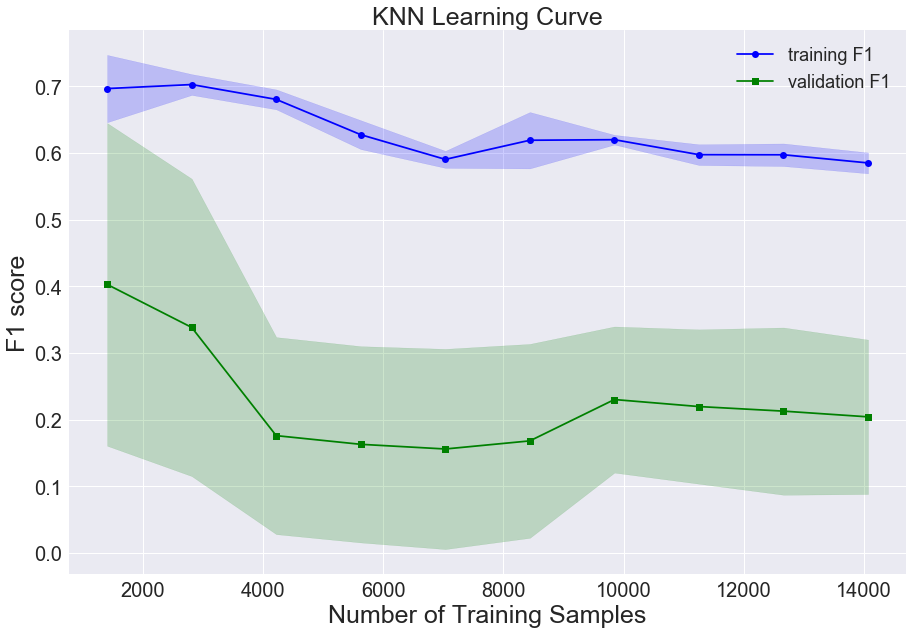

In [60]:
train_mean = np.mean(train_scores, axis = 1)
train_std = np.std(train_scores, axis =1)

test_mean = np.mean(test_scores, axis=1)
test_std = np.std(test_scores, axis=1)


fig = plt.figure(figsize=(15,10))
plt.plot(train_sizes,np.mean(train_scores, axis=1), color ='blue',marker = 'o', label ="training F1")
plt.plot(train_sizes, np.mean(test_scores, axis=1), color = 'green',marker = 's',label ="validation F1" )

plt.fill_between(train_sizes,
                train_mean + train_std,
                train_mean - train_std,
                alpha=0.2, color = 'blue')

plt.fill_between(train_sizes,
                test_mean + test_std,
                test_mean - test_std,
                alpha=0.2, color = 'green')


plt.title("KNN Learning Curve", fontsize = 25)
plt.xlabel('Number of Training Samples', fontsize = 25)
plt.ylabel('F1 score', fontsize = 25)
plt.tick_params(labelsize=20)
plt.legend(loc='upper right', fontsize = 18)

## Random Forest 

In [61]:
#Randomize the Issuer selected in train test
#Work what percent of entries the random set of 
#Instacart class imbalance notebook 
import numpy as np
np.random.seed(42)
unique_issuer_list = X_learning['IssuerId'].unique() 
test_set_issuers = np.random.choice(unique_issuer_list, size=int(unique_issuer_list.shape[0] * .20))

df_X_tr, df_X_te = X_analysis[~X_analysis['IssuerId'].isin(test_set_issuers)], X_analysis[X_analysis['IssuerId'].isin(test_set_issuers)]

y_tr, y_te = df_X_tr['Exit_County_Next_Year'], df_X_te['Exit_County_Next_Year']


features = ['Population_per_All_County_Plans', 'Expansion',
          'First_Year_in_County', 'Average_Median_Rate_in_State', 'State_Percent_Change_Rate_From_Prior_Year']

X_tr, X_te = df_X_tr[features], df_X_te[features]

In [62]:
X_tr = np.array(X_tr, dtype=np.float64)
X_te = np.array(X_te, dtype=np.float64)
y_tr = np.array(y_tr, dtype=np.float64)
y_te = np.array(y_te, dtype=np.float64)

In [63]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier(max_features = None)

param_grid = [{ "n_estimators" : [10, 50, 100],
               "max_depth" : [3,10,20],
               "min_samples_leaf" : [1, 5, 10]}]

grid = GridSearchCV(forest, param_grid = param_grid, 
                    cv=10, scoring='f1')
grid.fit(X_tr, y_tr)
grid.best_score_

0.27633647761015462

In [64]:
grid.best_params_

{'max_depth': 3, 'min_samples_leaf': 10, 'n_estimators': 10}

In [67]:
from sklearn.ensemble import RandomForestClassifier

forest = RandomForestClassifier(n_estimators = 10, max_depth = 3, 
                                max_features = None, min_samples_leaf = 10)

forest.fit(X_tr,y_tr)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [68]:
predictions = forest.predict(X_te)

In [69]:
accuracy_score(y_te, predictions)

0.60911854103343466

In [70]:
np.unique(predictions, return_counts=True)

(array([ 0.,  1.]), array([2482,  808]))

In [71]:
recall_score(y_te, predictions)

0.31921331316187596

In [72]:
precision_score(y_te,predictions)

0.5222772277227723

In [73]:
f1_score(y_te,predictions)

0.39624413145539905

## Holdout Set

In [75]:
features

['Population_per_All_County_Plans',
 'Expansion',
 'First_Year_in_County',
 'Average_Median_Rate_in_State',
 'State_Percent_Change_Rate_From_Prior_Year']

In [76]:
hold_out_test_set_issuers 

array([34762, 74917, 32904, 67243, 33871, 30252, 34762, 44811, 63509,
       67183, 44240, 89953, 39364, 85408, 45636, 93299, 42261, 92498,
       99969, 56707, 44794, 27357, 33851, 39924, 16724, 33380, 45127,
       31609, 74917, 64844, 75729, 68432, 59560, 84670, 93187, 39364,
       87928, 14650, 30252, 22444, 48608, 46275, 33670, 70525, 52697,
       99129, 35065, 71667, 78463, 49046, 63141, 45002, 68303, 44580,
       50816, 74483, 82824, 15411, 39996, 27248, 79763, 99389, 28020, 63631])

In [77]:
X_train,X_test,y_train,y_test = mc_analysis.get_train_test_data(X_analysis, hold_out_test_set_issuers,features)

In [87]:
forest = RandomForestClassifier(n_estimators = 10, max_depth = 3, 
                                max_features = None, min_samples_leaf = 10)


forest.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=3, max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [88]:
predictions = forest.predict(X_test)

In [89]:
accuracy_score(y_test, predictions)

0.51823708206686925

In [90]:
precision_score(y_test, predictions)

0.46073903002309469

In [91]:
recall_score(y_test, predictions)

0.21755725190839695

In [92]:
f1_score(y_test,predictions)

0.29555555555555557

In [84]:
np.unique(predictions, return_counts=True)

(array([ 0.,  1.]), array([3082,  866]))

In [85]:
importances = forest.feature_importances_
indices = np.argsort(importances)[::-1]

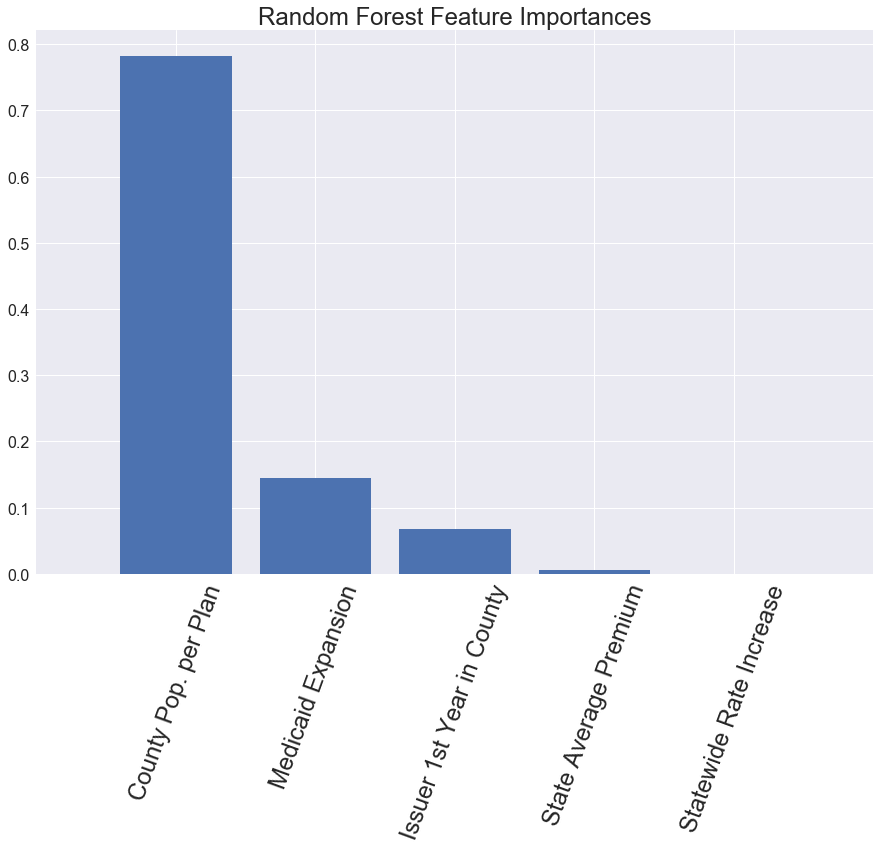

In [86]:
renamed_features_plotting = ["County Pop. per Plan", "Medicaid Expansion" , "Issuer 1st Year in County",
                            "State Average Premium", "Statewide Rate Increase"]

fig = plt.figure(figsize=(15,10))
plt.title ("Random Forest Feature Importances", fontsize=24)
plt.bar(range(X_train.shape[1]),
        importances[indices],
        align ='center')

plt.xticks(range(X_train.shape[1]),
           renamed_features_plotting, rotation=70, fontsize = 24)

plt.yticks(fontsize = 16)


plt.xlim([-1, X_train.shape[1]])

plt.show()